In [97]:
#Importing the basic librarires

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer,make_column_selector

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.exceptions import NotFittedError

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [81]:
df = pd.read_csv("/../content/DSMM 56 - Dataset for Carsy_cp.csv")

#df.drop(['dteday','instant'], axis=1, inplace=True)
display(df.head())

target = 'price'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \
0        mpfi       3.47    2.68              9.0        111     5000      21   
1        mpfi       3.47    2.68              9.0        111     5000      21   
2        mpfi       2.68    3.47              9.0        154     5000      19   
3        mpfi       3.19    3.40             10.0        102     5500      24   
4        mpfi       3.19    3.40              8.0        115     5500      18   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  

[5 rows x 26 columns]


Inference: The Datset consists of 26 features & 205 samples.


In [82]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [83]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

fueltype              2
aspiration            2
doornumber            2
enginelocation        2
drivewheel            3
carbody               5
symboling             6
enginetype            7
cylindernumber        7
fuelsystem            8
peakrpm              23
citympg              29
highwaympg           30
compressionratio     32
stroke               37
boreratio            38
carwidth             44
enginesize           44
carheight            49
wheelbase            53
horsepower           59
carlength            75
CarName             147
curbweight          171
price               189
car_ID              205
dtype: int64

In [84]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 15 numerical & 10 categorical features.


In [92]:
nf

['peakrpm',
 'citympg',
 'highwaympg',
 'compressionratio',
 'stroke',
 'boreratio',
 'carwidth',
 'enginesize',
 'carheight',
 'wheelbase',
 'horsepower',
 'carlength',
 'CarName',
 'curbweight',
 'car_ID']

In [85]:
#Checking the stats of all the columns

display(df.describe())

car_ID   symboling   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean   103.000000    0.834146   98.756585  174.049268   65.907805   53.724878   
std     59.322565    1.245307    6.021776   12.337289    2.145204    2.443522   
min      1.000000   -2.000000   86.600000  141.100000   60.300000   47.800000   
25%     52.000000    0.000000   94.500000  166.300000   64.100000   52.000000   
50%    103.000000    1.000000   97.000000  173.200000   65.500000   54.100000   
75%    154.000000    2.000000  102.400000  183.100000   66.900000   55.500000   
max    205.000000    3.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204   41.642693    0.270844    0.313597          3.972040   
min    1488.000000   61.000000    2.540000    2.070000          7.000000   
25%    2145.000000   97.000000    3.150000    3.110000          8.600000   
50%    2414.000000  120.000000    3.310000    3.290000          9.000000   
75%    2935.000000  141.000000    3.580000    3.410000          9.400000   
max    4066.000000  326.000000    3.940000    4.170000         23.000000   

       horsepower      peakrpm     citympg  highwaympg         price  
count  205.000000   205.000000  205.000000  205.000000    205.000000  
mean   104.117073  5125.121951   25.219512   30.751220  13276.710571  
std     39.544167   476.985643    6.542142    6.886443   7988.852332  
min     48.000000  4150.000000   13.000000   16.000000   5118.000000  
25%     70.000000  4800.000000   19.000000   25.000000   7788.000000  
50%     95.000000  5200.000000   24.000000   30.000000  10295.000000  
75%    116.000000  5500.000000   30.000000   34.000000  16503.000000  
max    288.000000  6600.000000   49.000000   54.000000  45400.000000

**2. Exploratory Data Analysis (EDA)**

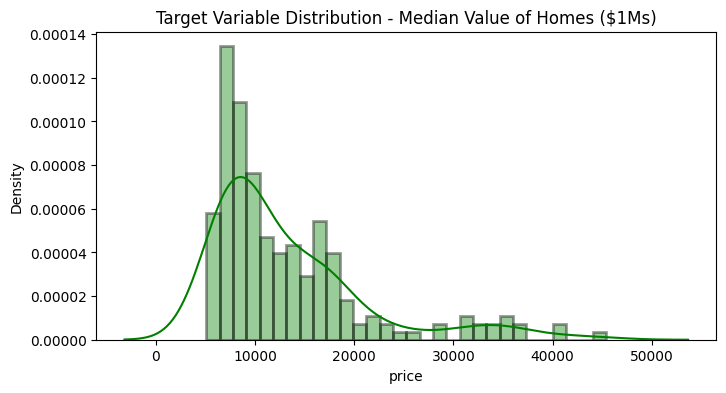

In [86]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

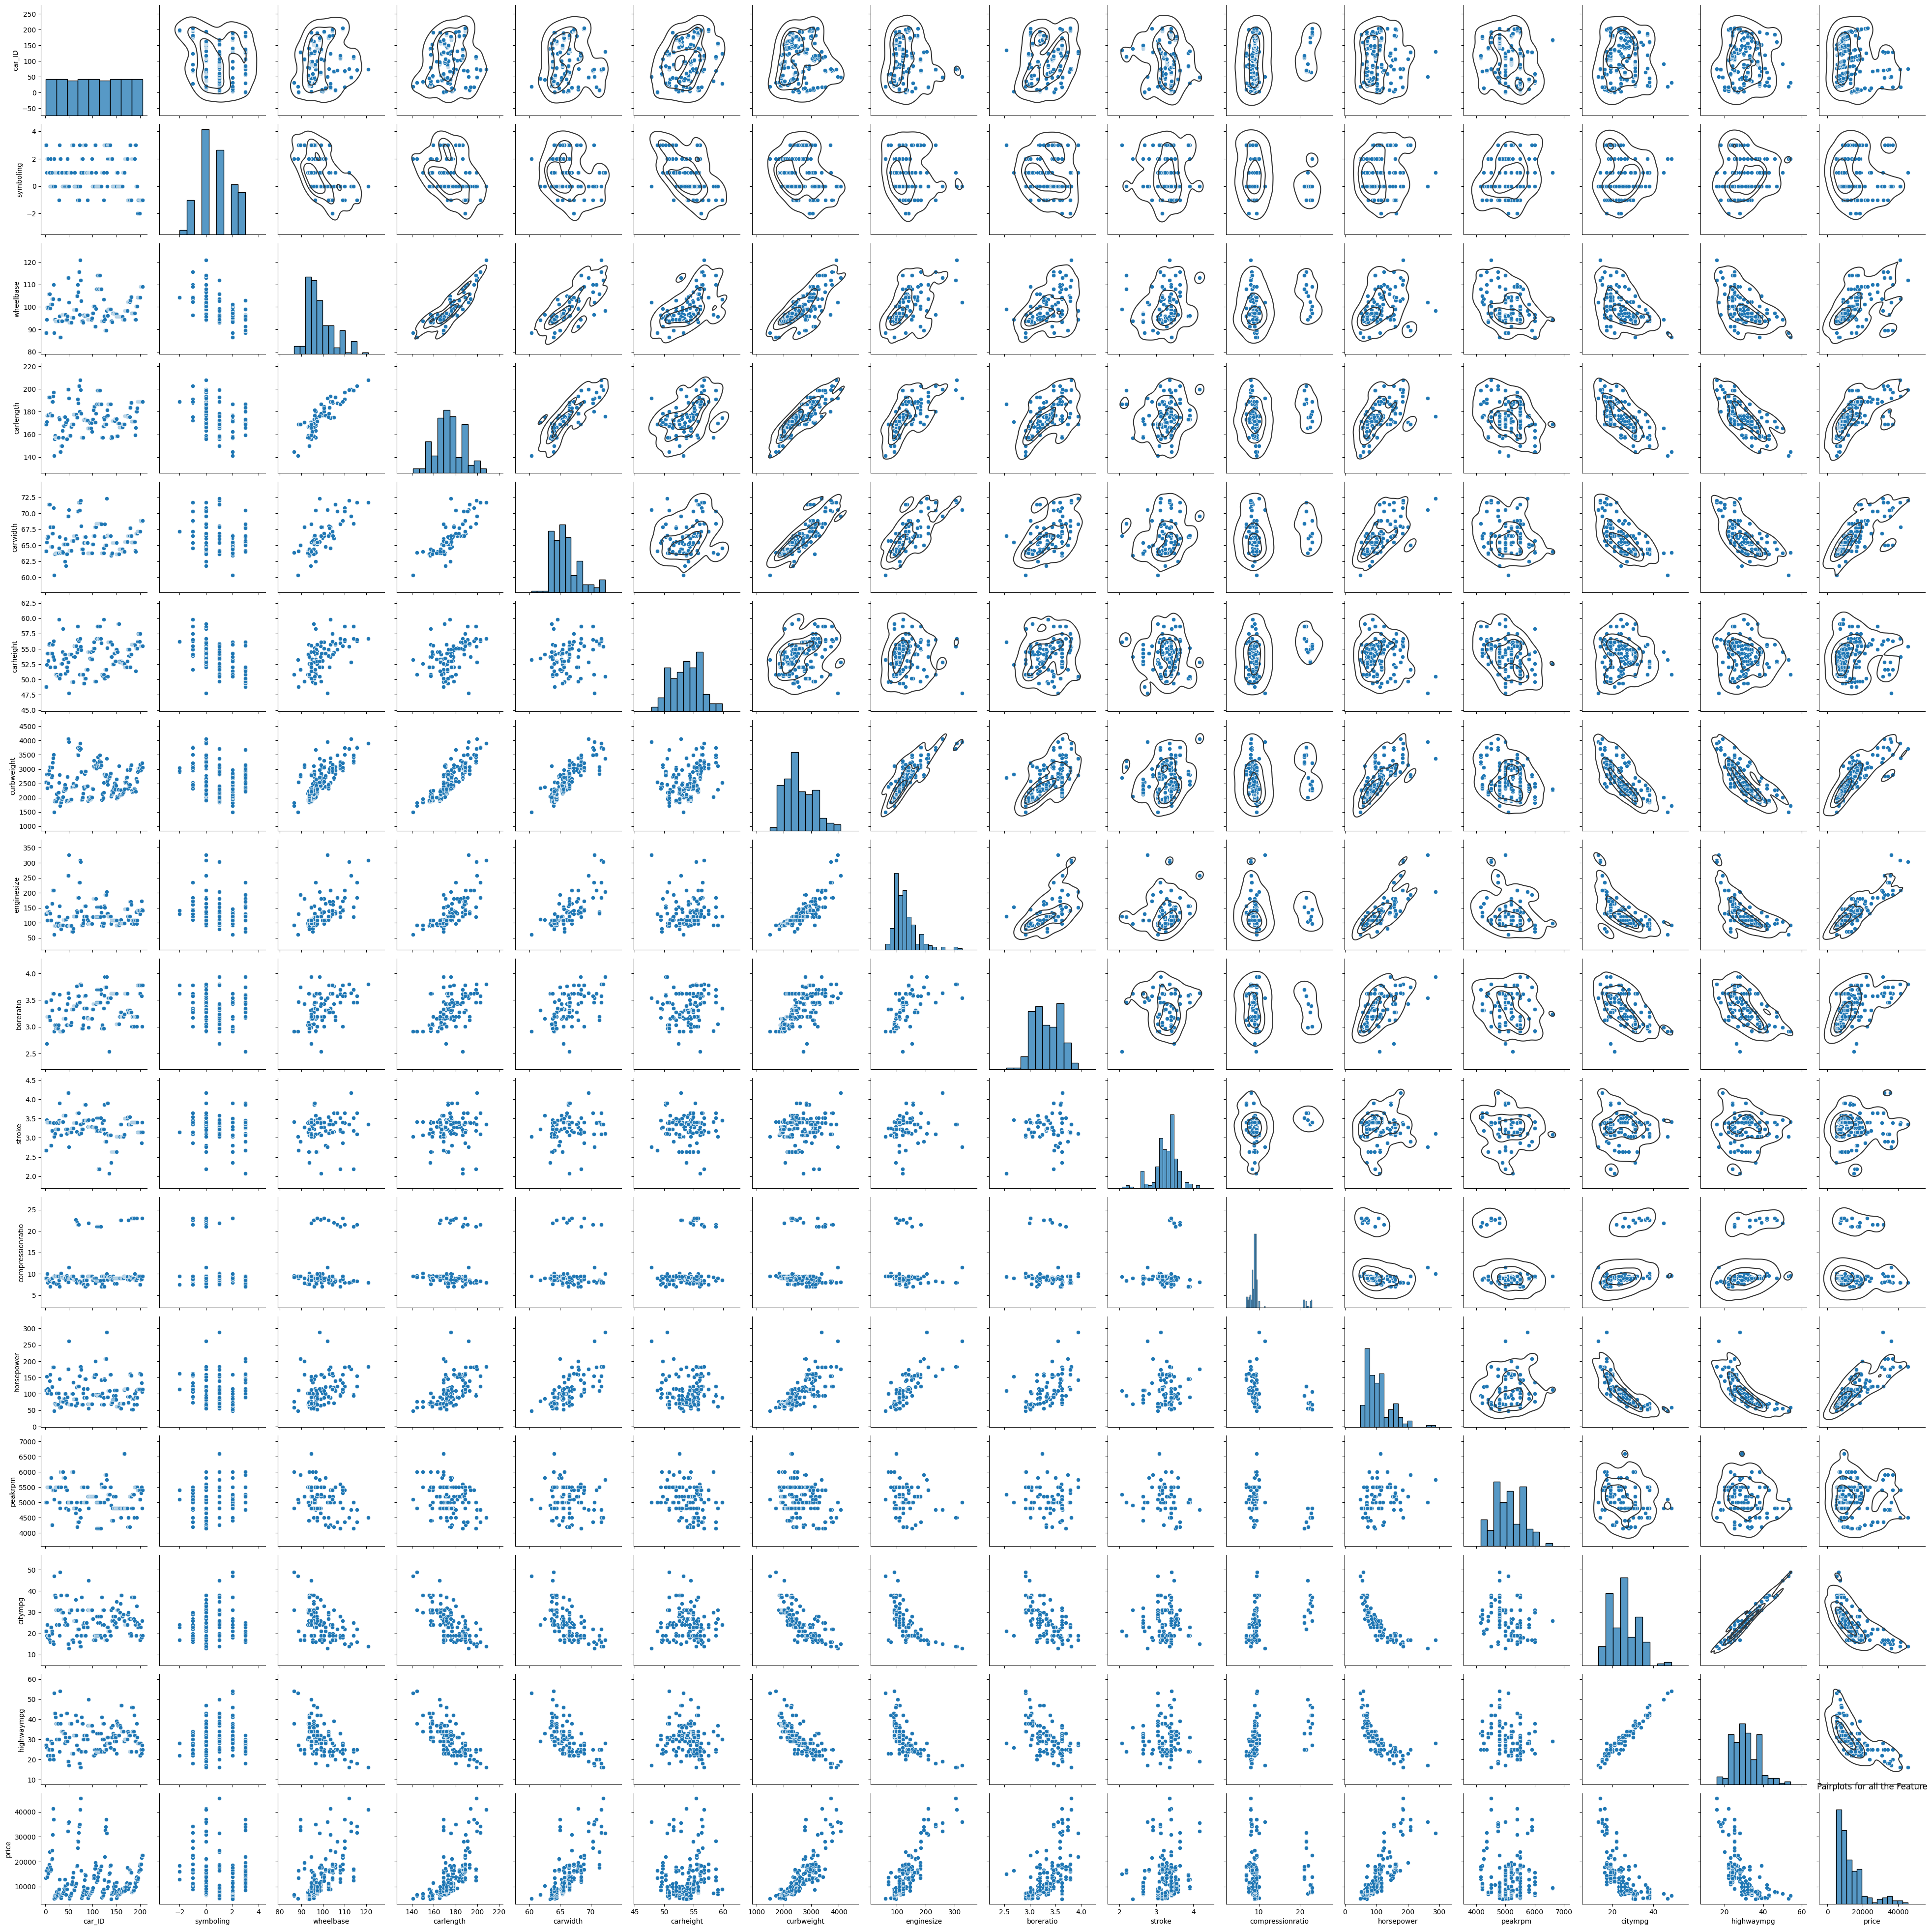

In [87]:
#Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

In [88]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [89]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
car_ID                            0         0.0
citympg                           0         0.0
peakrpm                           0         0.0
horsepower                        0         0.0
compressionratio                  0         0.0
stroke                            0         0.0
boreratio                         0         0.0
fuelsystem                        0         0.0
enginesize                        0         0.0
cylindernumber                    0         0.0
enginetype                        0         0.0
curbweight                        0         0.0
carheight                         0         0.0
carwidth                          0         0.0
carlength                         0         0.0
wheelbase                         0         0.0
enginelocation                    0         0.0
drivewheel                        0         0.0
carbody                           0         0.0
doornumber                        0     

In [90]:
#Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape

One-Hot Encoding on features:
enginelocation
fueltype
aspiration
doornumber

Dummy Encoding on features:
drivewheel
carbody
symboling
cylindernumber
enginetype
fuelsystem


(205, 50)

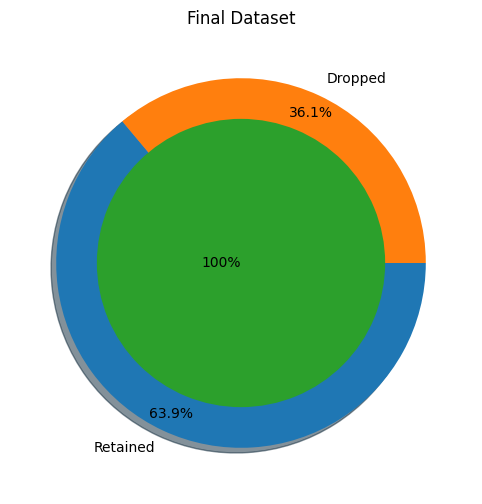


Inference: After the cleanup process, 74 samples were dropped, while retaining 36.1% of the data.


In [94]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

**4. Data Manipulation**

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   car_ID                 131 non-null    int64  
 1   CarName                131 non-null    object 
 2   fueltype               131 non-null    uint8  
 3   aspiration             131 non-null    uint8  
 4   doornumber             131 non-null    uint8  
 5   enginelocation         131 non-null    uint8  
 6   wheelbase              131 non-null    float64
 7   carlength              131 non-null    float64
 8   carwidth               131 non-null    float64
 9   carheight              131 non-null    float64
 10  curbweight             131 non-null    int64  
 11  enginesize             131 non-null    int64  
 12  boreratio              131 non-null    float64
 13  stroke                 131 non-null    float64
 14  compressionratio       131 non-null    float64
 15  horsep

In [118]:
oh=OneHotEncoder(drop='first',handle_unknown='ignore')

ms,ss=MinMaxScaler(),StandardScaler()


ct=ColumnTransformer([
    ('cat_encoder',oh,make_column_selector(dtype_include='object')),
    ('num_encoder',ms,make_column_selector(dtype_include='float64'))
],remainder='passthrough',n_jobs=-1)

In [119]:
X=df.drop([target],axis=1)

y=df[[target]]
X.head(1)

car_ID             CarName  fueltype  aspiration  doornumber  \
0       1  alfa-romero giulia         1           0           1   

   enginelocation  wheelbase  carlength  carwidth  carheight  ...  \
0               0       88.6      168.8      64.1       48.8  ...   

   enginetype_ohcf  enginetype_ohcv  enginetype_rotor  fuelsystem_2bbl  \
0                0                0                 0                0   

   fuelsystem_4bbl  fuelsystem_idi  fuelsystem_mfi  fuelsystem_mpfi  \
0                0               0               0                1   

   fuelsystem_spdi  fuelsystem_spfi  
0                0                0  

[1 rows x 49 columns]

In [120]:
y.head(1)

price
0  13495.0

**Train Test Split**

In [121]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=108)

In [122]:
X_train.shape,y_train.shape

((104, 49), (104, 1))

In [123]:
X_test.shape,y_test.shape

((27, 49), (27, 1))

**Data preprocess**

In [124]:
X_train=ct.fit_transform(X_train)
X_test=ct.transform(X_test)

In [125]:
print("-"*50)
for i in ct.transformers_:
    print(i)
    if(i[0]!='remainder'):
        print(i[1].get_feature_names_out())
    print("-"*50)

--------------------------------------------------
('cat_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'), ['CarName'])
['CarName_alfa-romero Quadrifoglio' 'CarName_alfa-romero stelvio'
 'CarName_audi 100 ls' 'CarName_audi 100ls' 'CarName_bmw 320i'
 'CarName_bmw x1' 'CarName_bmw x3' 'CarName_chevrolet monte carlo'
 'CarName_dodge challenger se' 'CarName_dodge colt hardtop'
 'CarName_dodge d200' 'CarName_dodge dart custom' 'CarName_honda accord'
 'CarName_honda accord cvcc' 'CarName_honda accord lx'
 'CarName_honda civic (auto)' 'CarName_honda civic 1300'
 'CarName_honda civic 1500 gl' 'CarName_honda civic cvcc'
 'CarName_honda prelude' 'CarName_isuzu D-Max ' 'CarName_isuzu MU-X'
 'CarName_maxda glc deluxe' 'CarName_maxda rx3' 'CarName_mazda 626'
 'CarName_mazda glc' 'CarName_mazda glc custom' 'CarName_mazda glc deluxe'
 'CarName_mazda rx-4' 'CarName_mazda rx-7 gs' 'CarName_mazda rx2 coupe'
 'CarName_mercury cougar' 'CarName_mitsubishi g4'
 'CarName_mitsubishi lancer' 'Car

In [126]:
X_train.shape,y_train.shape

((104, 130), (104, 1))

In [127]:
tup1=None;tup2=None
try:
    tup1=(X_test[0].toarray(),y_test.head(1).values)  # scientific notation
    print("Sparse Matrix to Dense Array")
except:
    tup2=(X_test[0],y_test.head(1).values)
    print("Normal Matrix to Dense Array")

tup1 if(tup1) else tup2

Normal Matrix to Dense Array


(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [128]:
X_test.shape,y_test.shape

((27, 130), (27, 1))

**Model fitting**

In [129]:
def print_model_locations(model_list):
    print("-"*80)
    for i,model in enumerate(model_list):
        print(model)
        print(f"{model.__class__.__name__:50} at index {i}")
        print("-"*80)

In [130]:
def model_fitter(model_list):
    print("-"*80)
    for reg in model_list:
        reg_name=reg.__class__.__name__
        reg.fit(X_train,y_train.values.ravel())
        print(f"Fitting {reg_name} done")
        print("-"*80)

In [131]:
from sklearn.linear_model import LinearRegression,SGDRegressor

from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

In [132]:
reg_list=[
    DecisionTreeRegressor(),
    LinearRegression(n_jobs=-1),
    RandomForestRegressor(n_estimators=200,n_jobs=-1),
    AdaBoostRegressor(n_estimators=200,learning_rate=0.1),
    XGBRegressor(n_estimators=200,learning_rate=0.1,n_jobs=-1),
    LGBMRegressor(n_estimators=200,learning_rate=0.1,n_jobs=-1),
    GradientBoostingRegressor(n_estimators=200,learning_rate=0.1),
]

In [133]:
reg_list_copy=[
    DecisionTreeRegressor(),
    LinearRegression(n_jobs=1),
    RandomForestRegressor(n_estimators=200,n_jobs=-1),
    AdaBoostRegressor(n_estimators=200,learning_rate=0.1),
    XGBRegressor(n_estimators=200,learning_rate=0.1,tree_method='gpu_hist',n_jobs=-1),
    LGBMRegressor(n_estimators=200,learning_rate=0.1,device='gpu',n_jobs=-1),
    GradientBoostingRegressor(n_estimators=200,learning_rate=0.1),
]

In [134]:
print_model_locations(reg_list)

--------------------------------------------------------------------------------
DecisionTreeRegressor()
DecisionTreeRegressor                              at index 0
--------------------------------------------------------------------------------
LinearRegression(n_jobs=-1)
LinearRegression                                   at index 1
--------------------------------------------------------------------------------
RandomForestRegressor(n_estimators=200, n_jobs=-1)
RandomForestRegressor                              at index 2
--------------------------------------------------------------------------------
AdaBoostRegressor(learning_rate=0.1, n_estimators=200)
AdaBoostRegressor                                  at index 3
--------------------------------------------------------------------------------
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
     

In [135]:
%%time
model_fitter(reg_list)

--------------------------------------------------------------------------------
Fitting DecisionTreeRegressor done
--------------------------------------------------------------------------------
Fitting LinearRegression done
--------------------------------------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------------------------------------
Fitting AdaBoostRegressor done
--------------------------------------------------------------------------------
Fitting XGBRegressor done
--------------------------------------------------------------------------------
Fitting LGBMRegressor done
--------------------------------------------------------------------------------
Fitting GradientBoostingRegressor done
--------------------------------------------------------------------------------
CPU times: user 1.75 s, sys: 154 ms, total: 1.9 s
Wall time: 1.48 s


**Testing**

In [136]:
def tester_func(model_list):
    for i,reg in enumerate(model_list):

        reg_name = reg.__class__.__name__
        pred=None

        try:
            pred=reg.predict(X_test)
        except NotFittedError as e:
            raise(e)

        print("-"*80)
        print(f"Predicitng {reg_name:40} done")

        score_dict[reg_name]={
            "R2 Score":r2_score(y_test,pred),
            "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False),
            "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
            "Mean Squared Error Score":mean_squared_error(y_test,pred),
            'model_index':int(i)
        }
        j=i

    print("-"*80)

    return j

In [138]:
score_dict={};j=0
j_copy=tester_func(reg_list)
j_copy

--------------------------------------------------------------------------------
Predicitng DecisionTreeRegressor                    done
--------------------------------------------------------------------------------
Predicitng LinearRegression                         done
--------------------------------------------------------------------------------
Predicitng RandomForestRegressor                    done
--------------------------------------------------------------------------------
Predicitng AdaBoostRegressor                        done
--------------------------------------------------------------------------------
Predicitng XGBRegressor                             done
--------------------------------------------------------------------------------
Predicitng LGBMRegressor                            done
--------------------------------------------------------------------------------
Predicitng GradientBoostingRegressor                done
----------------------------------

6

In [139]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values('Root Mean Squared Error')
score_pd

R2 Score  Root Mean Squared Error  \
RandomForestRegressor      0.848568              1568.000510   
GradientBoostingRegressor  0.844587              1588.473396   
AdaBoostRegressor          0.811597              1748.963634   
LGBMRegressor              0.797593              1812.797372   
XGBRegressor               0.795737              1821.089426   
DecisionTreeRegressor      0.601252              2544.404691   
LinearRegression           0.329835              3298.585339   

                           Mean Absolute Error Score  \
RandomForestRegressor                     980.863241   
GradientBoostingRegressor                1078.000875   
AdaBoostRegressor                        1178.466925   
LGBMRegressor                            1243.388002   
XGBRegressor                             1142.538918   
DecisionTreeRegressor                    1485.648148   
LinearRegression                         2666.464260   

                           Mean Squared Error Score  model_index  
RandomForestRegressor                  2.458626e+06          2.0  
GradientBoostingRegressor              2.523248e+06          6.0  
AdaBoostRegressor                      3.058874e+06          3.0  
LGBMRegressor                          3.286234e+06          5.0  
XGBRegressor                           3.316367e+06          4.0  
DecisionTreeRegressor                  6.473995e+06          0.0  
LinearRegression                       1.088067e+07          1.0

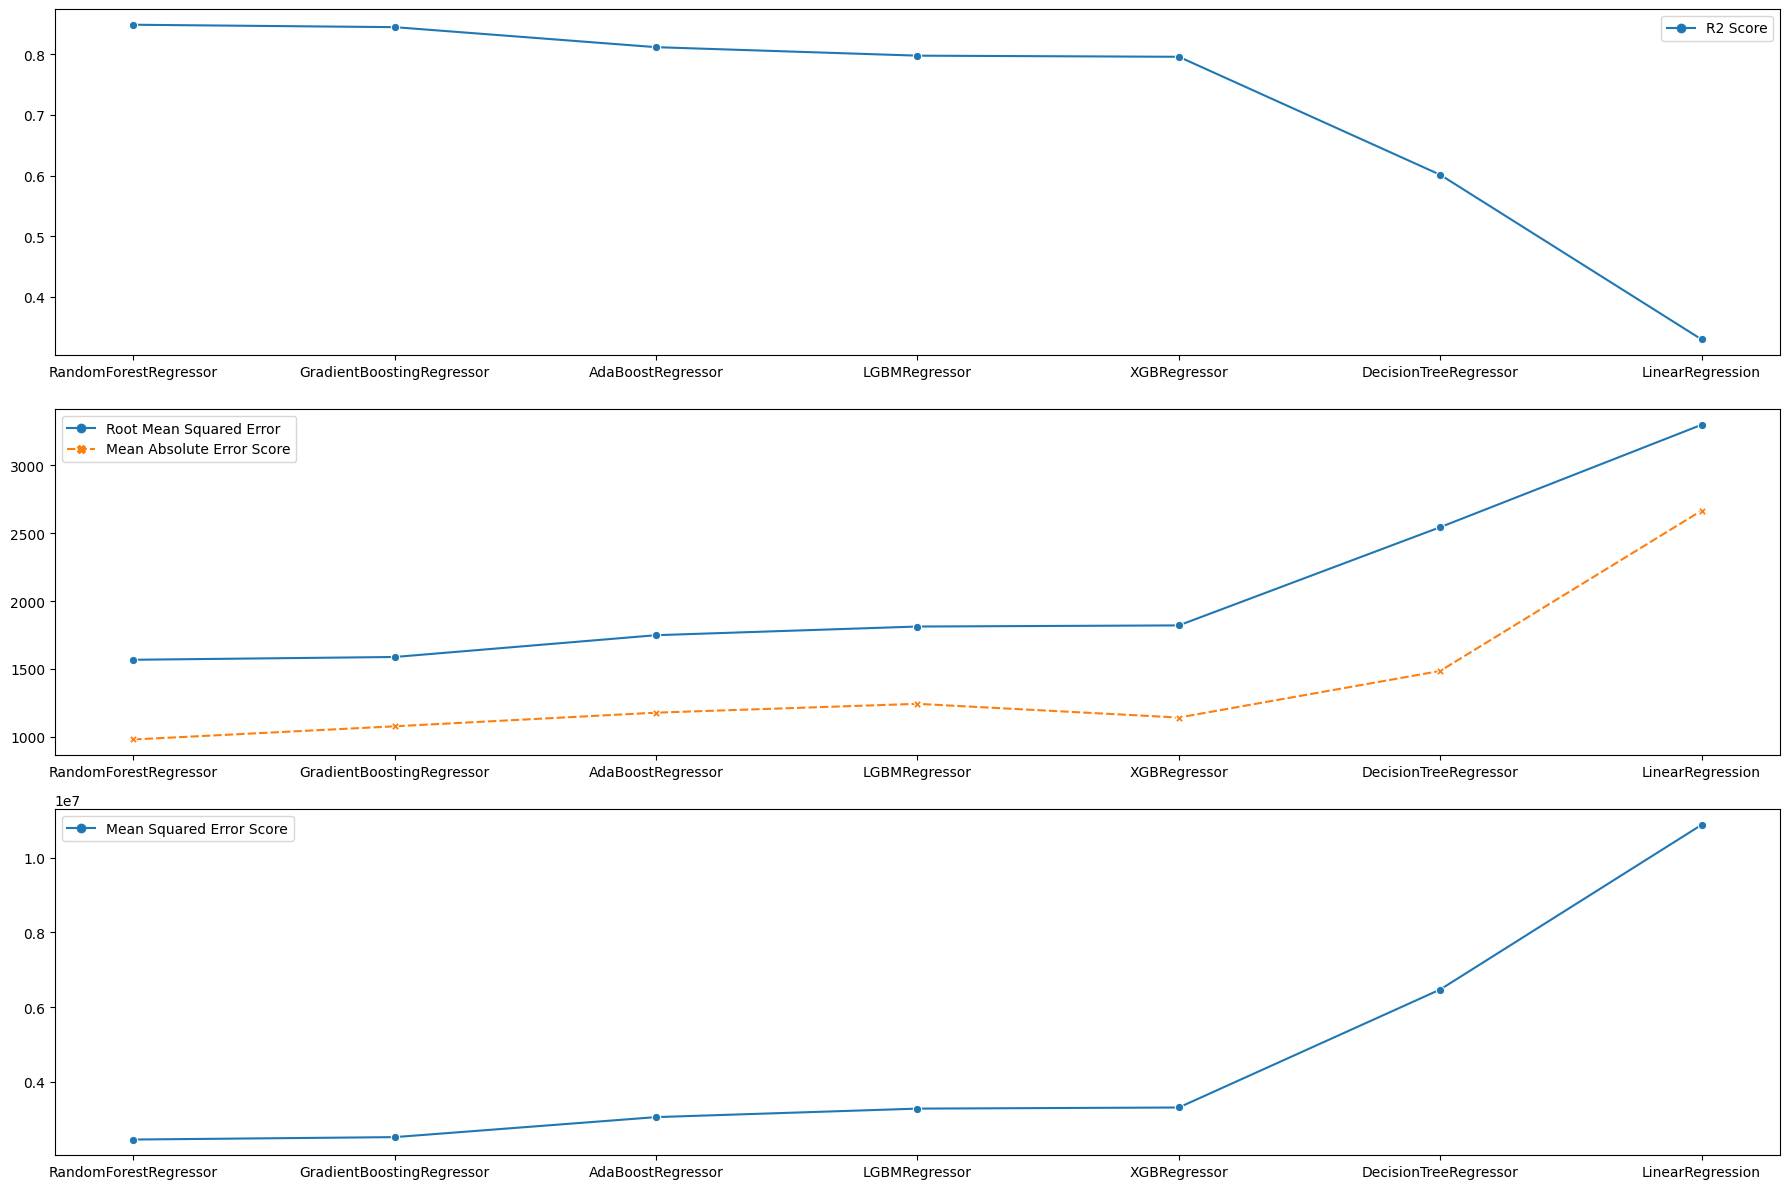

In [140]:
fig,ax=plt.subplots(3,1,figsize=(18,12))
sns.lineplot(data=score_pd.iloc[:,[1,2]],markers=True,ax=ax[1])
sns.lineplot(data=score_pd.iloc[:,[0]],markers=True,ax=ax[0])
sns.lineplot(data=score_pd.iloc[:,[3]],markers=True,ax=ax[2])
plt.tight_layout()
plt.show()

**Best Model Plot**

In [141]:
score_pd.iloc[[0],:]

R2 Score  Root Mean Squared Error  \
RandomForestRegressor  0.848568               1568.00051   

                       Mean Absolute Error Score  Mean Squared Error Score  \
RandomForestRegressor                 980.863241              2.458626e+06   

                       model_index  
RandomForestRegressor          2.0

In [142]:
win_index=int(score_pd.iloc[0,-1])
win_index

2

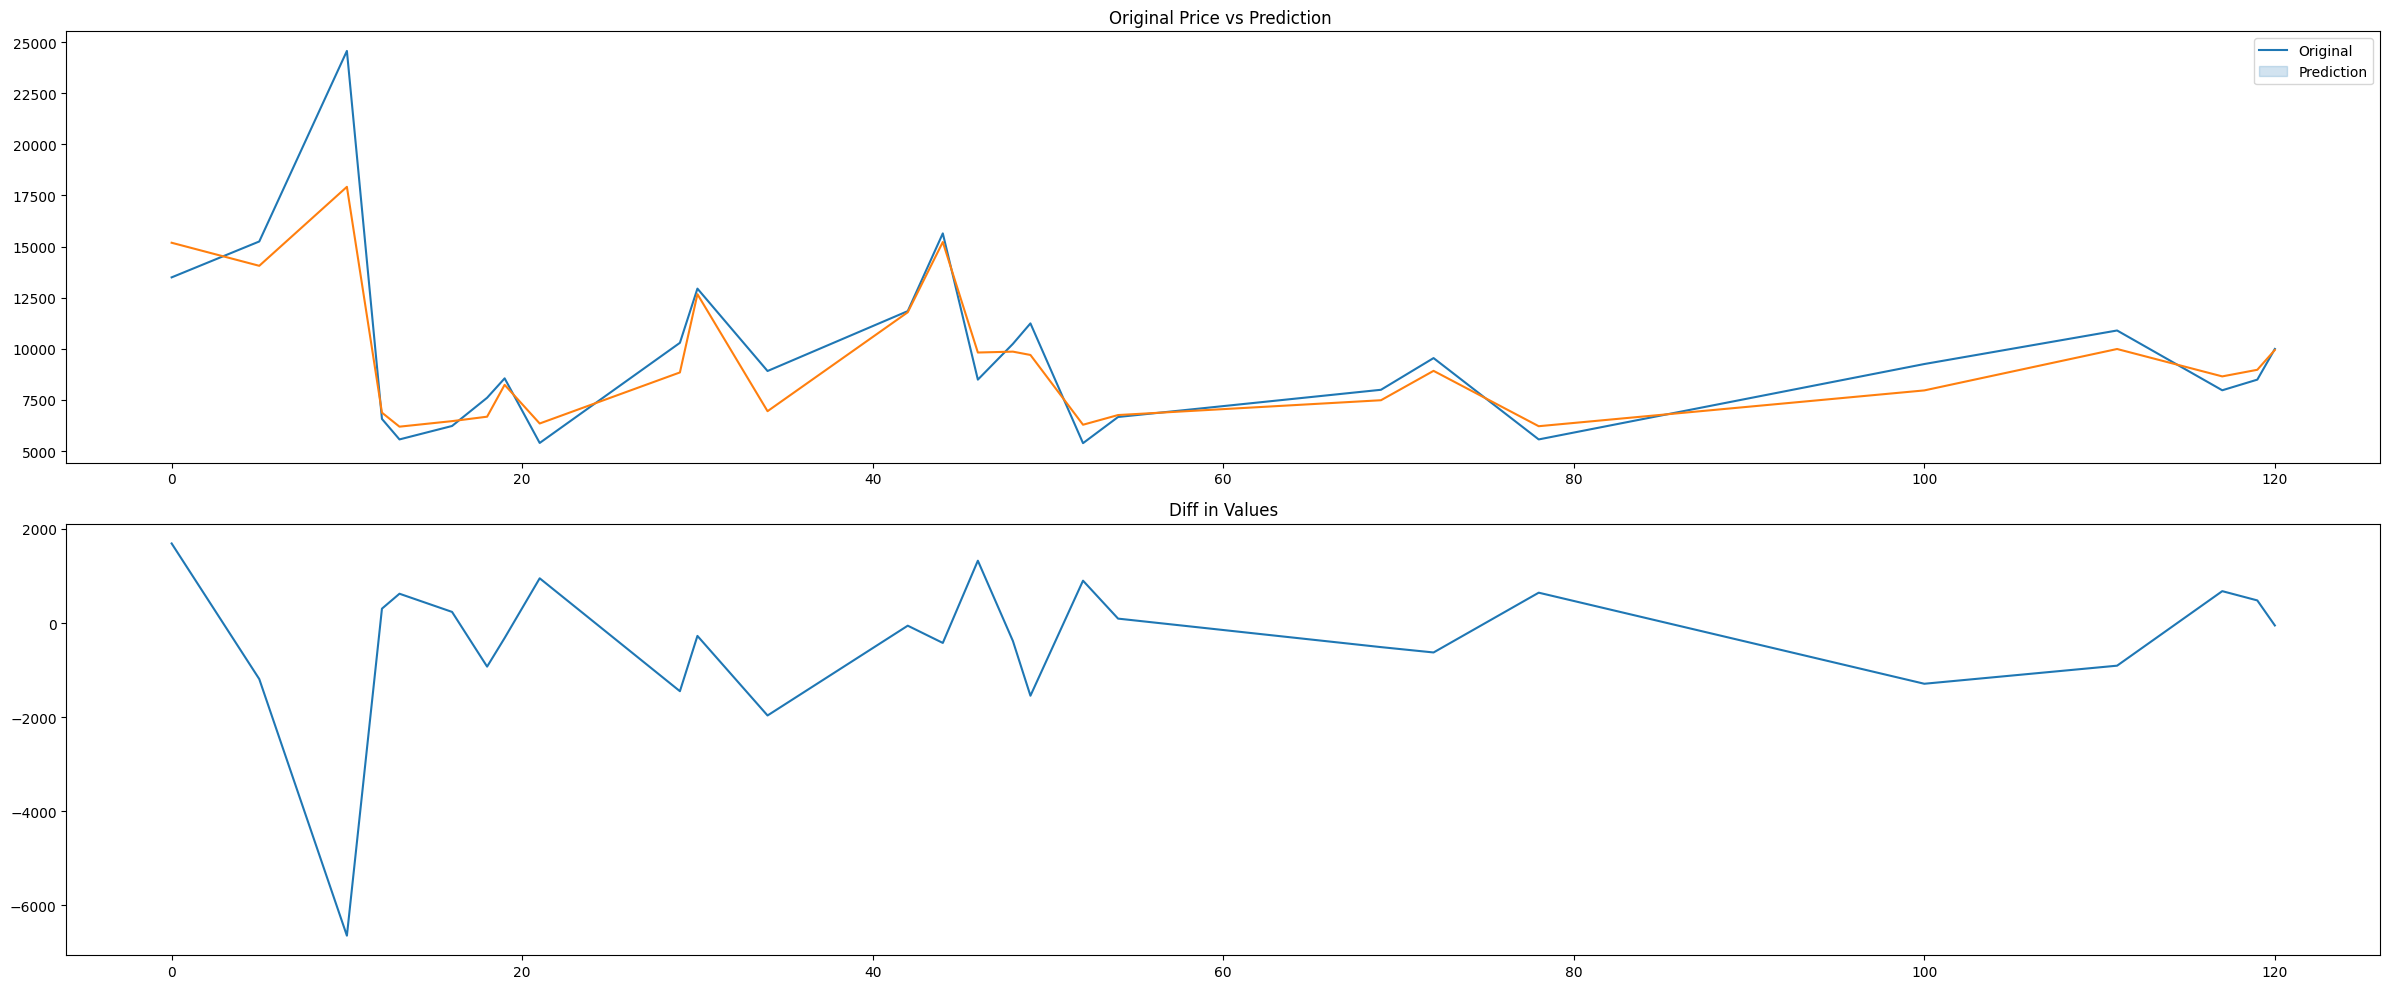

In [143]:
pred=reg_list[win_index].predict(X_test)
diff=pred-y_test.values.ravel()

fig,ax=plt.subplots(2,1,figsize=(24,10))
sns.lineplot(y=y_test.values.ravel(),x=y_test.index,legend=False,ax=ax[0])
sns.lineplot(y=pred,x=y_test.index,legend=False,ax=ax[0])
sns.lineplot(y=diff,x=y_test.index,legend="full",ax=ax[1])
ax[0].set_title('Original Price vs Prediction ')
ax[0].legend(['Original','Prediction'])
ax[1].set_title('Diff in Values')
plt.tight_layout()
plt.show()

**Hyper parameter Tuning**

In [144]:
reg_list_copy[win_index].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [145]:
params=dict(n_estimators=np.arange(100,501,100),learning_rate=np.arange(0.1,1.1,0.1))

params

{'n_estimators': array([100, 200, 300, 400, 500]),
 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

In [146]:
gs=GridSearchCV(estimator=reg_list_copy[win_index],param_grid=params,verbose=3,cv=3,n_jobs=-1)
gs

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'n_estimators': array([100, 200, 300, 400, 500])},
             verbose=3)

In [147]:
reg_list.append(gs)
print_model_locations(reg_list)

--------------------------------------------------------------------------------
DecisionTreeRegressor()
DecisionTreeRegressor                              at index 0
--------------------------------------------------------------------------------
LinearRegression(n_jobs=-1)
LinearRegression                                   at index 1
--------------------------------------------------------------------------------
RandomForestRegressor(n_estimators=200, n_jobs=-1)
RandomForestRegressor                              at index 2
--------------------------------------------------------------------------------
AdaBoostRegressor(learning_rate=0.1, n_estimators=200)
AdaBoostRegressor                                  at index 3
--------------------------------------------------------------------------------
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
     

In [151]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values('Root Mean Squared Error')
score_pd

R2 Score  Root Mean Squared Error  \
RandomForestRegressor      0.848568              1568.000510   
GradientBoostingRegressor  0.844587              1588.473396   
AdaBoostRegressor          0.811597              1748.963634   
LGBMRegressor              0.797593              1812.797372   
XGBRegressor               0.795737              1821.089426   
DecisionTreeRegressor      0.601252              2544.404691   
LinearRegression           0.329835              3298.585339   

                           Mean Absolute Error Score  \
RandomForestRegressor                     980.863241   
GradientBoostingRegressor                1078.000875   
AdaBoostRegressor                        1178.466925   
LGBMRegressor                            1243.388002   
XGBRegressor                             1142.538918   
DecisionTreeRegressor                    1485.648148   
LinearRegression                         2666.464260   

                           Mean Squared Error Score  model_index  
RandomForestRegressor                  2.458626e+06          2.0  
GradientBoostingRegressor              2.523248e+06          6.0  
AdaBoostRegressor                      3.058874e+06          3.0  
LGBMRegressor                          3.286234e+06          5.0  
XGBRegressor                           3.316367e+06          4.0  
DecisionTreeRegressor                  6.473995e+06          0.0  
LinearRegression                       1.088067e+07          1.0

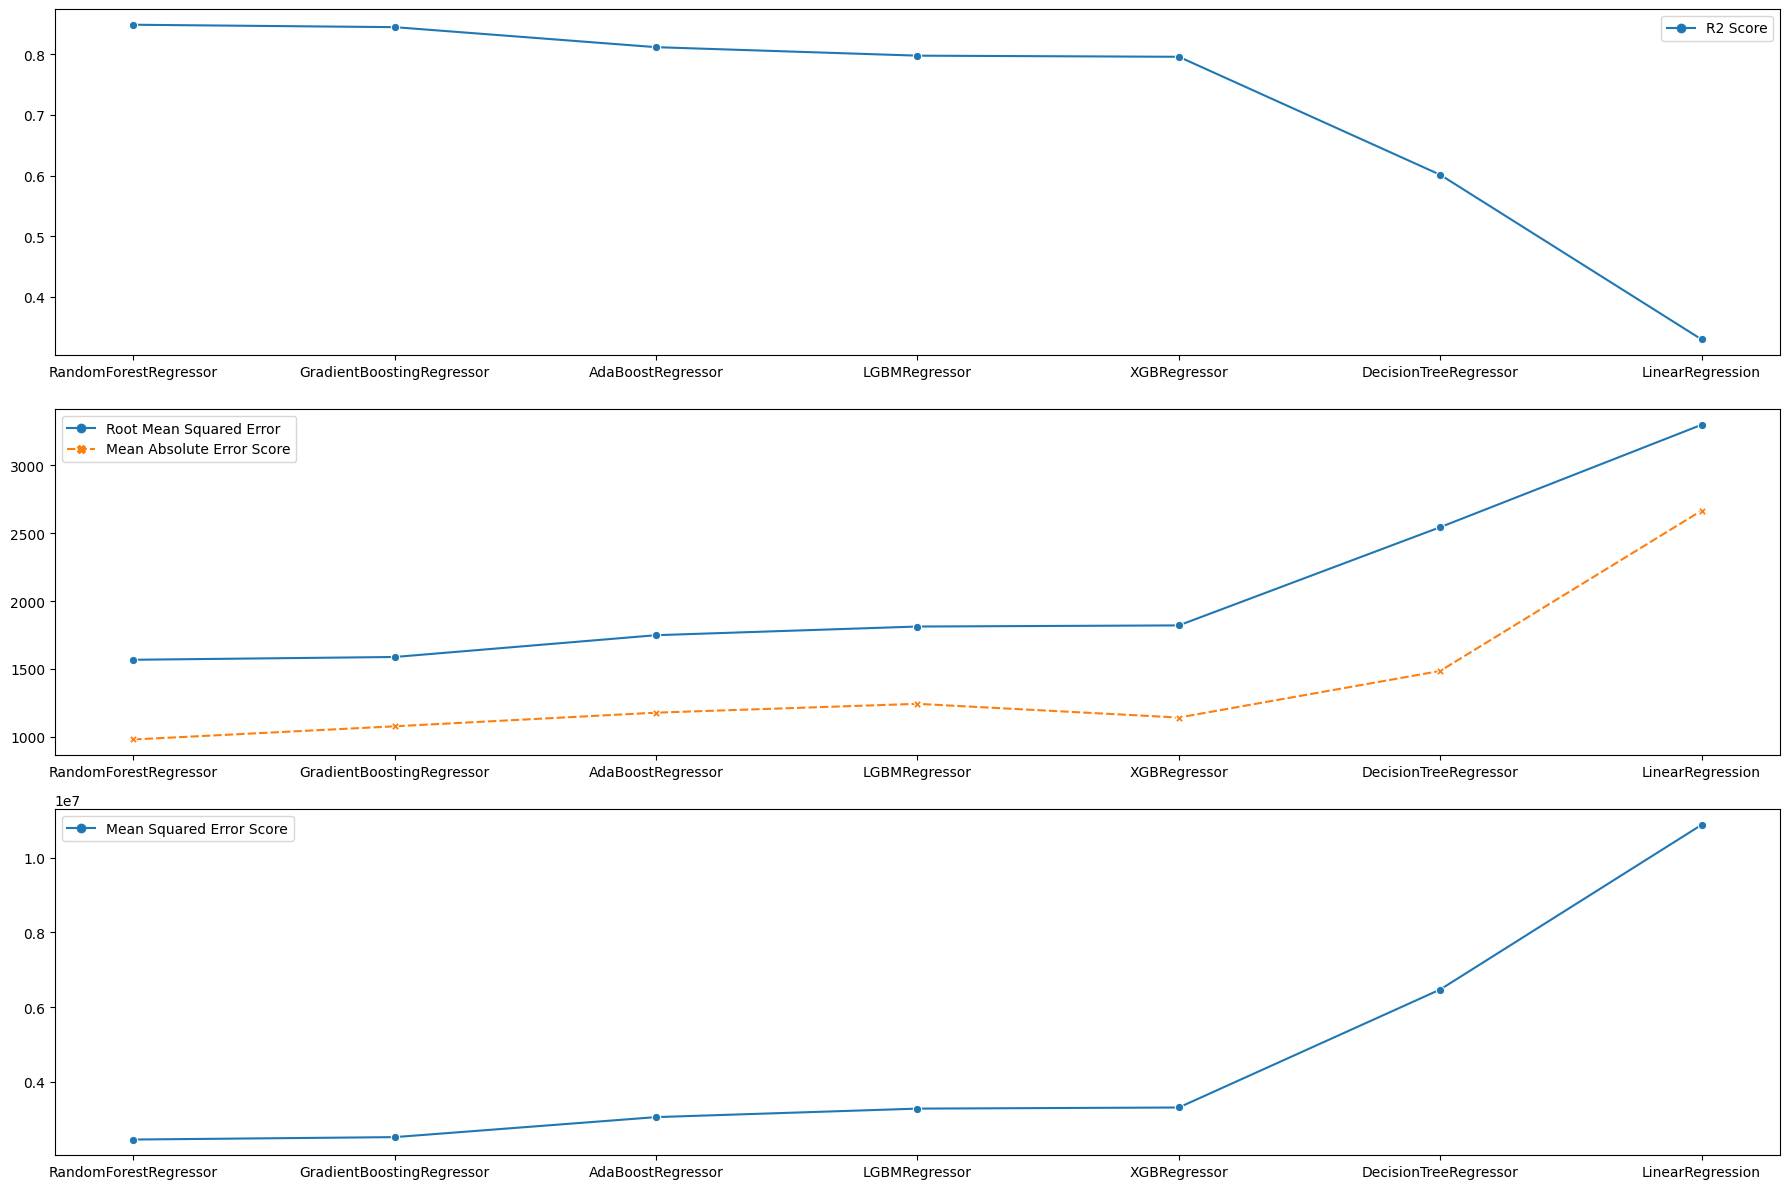

In [152]:
fig,ax=plt.subplots(3,1,figsize=(18,12))
sns.lineplot(data=score_pd.iloc[:,[1,2]],markers=True,ax=ax[1])
sns.lineplot(data=score_pd.iloc[:,[0]],markers=True,ax=ax[0])
sns.lineplot(data=score_pd.iloc[:,[3]],markers=True,ax=ax[2])
plt.tight_layout()
plt.show()